## 1.Package Import

In [0]:
import pandas as pd
import numpy as np
import os
import json
import tempfile
import datetime
import re, string, unicodedata


In [0]:
!pip install prince
import prince

## 2. Data Loading

In [0]:
import prince

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
def read_csv(uploaded, name):
  from io import StringIO
  s=str(uploaded[name],'utf-8')
  data = StringIO(s) 
  df=pd.read_csv(data)
  return df

In [0]:
#business side info of sample
link = "https://drive.google.com/open?id=1UacX5fkE-p3pLC9rdzow-74JIkmXA6Yn"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./bus_sub_sideinfo.csv')
sub_sideinfo = pd.read_csv('./bus_sub_sideinfo.csv', index_col = 0)
print(len(sub_sideinfo))
sub_sideinfo.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


158525


,business_id,stars,review_count,Alcohol(beer_and_wine),WheelchairAccessible,Ambience(classy),WiFi(free),Music(jukebox),BikeParking,BusinessParking(garage),BusinessParking(validated),NoiseLevel(quiet),NoiseLevel(very_loud),GoodForMeal(breakfast),DietaryRestrictions(halal),Music(background_music),DietaryRestrictions(gluten-free),HairSpecializesIn(africanamerican),Caters,NoiseLevel(None),HairSpecializesIn(coloring),HairSpecializesIn(perms),RestaurantsGoodForGroups,GoodForMeal(dinner),RestaurantsTakeOut,DietaryRestrictions(vegan),Music(video),Ambience(trendy),HairSpecializesIn(straightperms),RestaurantsCounterService,BusinessAcceptsCreditCards,RestaurantsTableService,OutdoorSeating,HairSpecializesIn(kids),DietaryRestrictions(dairy-free),Ambience(upscale),GoodForMeal(lunch),GoodForMeal(brunch),NoiseLevel(average),Ambience(casual),...,Performing Arts,Arts & Entertainment,Building Supplies,Cafes,Signmaking,Sports Medicine,Bakeries,Local Fish Stores,Australian,Junk Removal & Hauling,Wine Tasting Classes,Horse Equipment Shops,Leather Goods,Computers,Event Planning & Services,Sandwiches,Pet Training,Environmental Abatement,Batting Cages,Vintage & Consignment,Audiologist,Visitor Centers,Telecommunications,Bail Bondsmen,Aerial Tours,Hindu Temples,Gutter Services,Apartments,Apartment Agents,Emergency Rooms,Swiss Food,Landscape Architects,Cheese Shops,Karate,Gas Stations,Gastropubs,Home & Rental Insurance,Candle Stores,Safe Stores,American (New)
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,128,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,gnKjwL_1w79qoiV3IC_xQQ,4.0,170,1,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,xvX2CttrVhyG2z1dFg_0xw,5.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HhyxOkGAM07SRYtlQ4wMFQ,4.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,68dUKd8_8liJ7in4aWOSEA,2.5,3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
new_sideinfo = sub_sideinfo.iloc[:, 1:]
print (len(new_sideinfo))

158525


In [0]:
## data cleaning
for i in range(len(new_sideinfo.columns)):
  new_sideinfo.iloc[:,i] = new_sideinfo.iloc[:,i].apply(lambda x: (int(x) if x != 'None' else 0) if isinstance(x,str) else x)


## 3. Dropped tags where less than 50 businesses own it

In [0]:
## Dropped tags where less than 50 businesses own it
business_tags_amount = 0
stat = []
for i in new_sideinfo.columns:
    amount = sum(new_sideinfo[i])
    stat.append([i, amount])

new_tags = []
for i in stat:
  if list(i)[1]>50:
    business_tags_amount += 1
    new_tags.append(list(i)[0])
print(business_tags_amount)

reduced_sideinfo = new_sideinfo[new_tags]

807


## 4. MCA

Multiple correspondence analysis (MCA) is an extension of correspondence analysis (CA). It should be used when you have more than two categorical variables. The idea is simply to compute the one-hot encoded version of a dataset and apply CA on it.

In [0]:
def mcaHT(new_sideinfo, n_components = 50):
    mca = prince.MCA(n_components,
                 n_iter=3,
                 copy=True,
                 check_input=True,
                 engine='auto',
                 random_state=42)
    mca = mca.fit(new_sideinfo)
    explained_inertia = mca.explained_inertia_
    sum_explained_inertia = sum(mca.explained_inertia_)
    result = mca.transform(new_sideinfo)   
    return result, explained_inertia, sum_explained_inertia


In [0]:
total_inertia = []

In [0]:
# n_componets = 10
result_10m, exp_inertia_10, sum_exp_inertia_10 = mcaHT(reduced_sideinfo, n_components = 10)
total_inertia.append(sum_exp_inertia_10)
print('explained inertia for 10 components', exp_inertia_10)
print('total inertia for 10 components', sum_exp_inertia_10)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 10 components [0.014442001128761645, 0.004988543939325971, 0.004753486120463375, 0.0034440593230665832, 0.0026388707490265736, 0.00241812396314754, 0.002217413224057834, 0.0021675421207490515, 0.002082819967902354, 0.001906670967274948]
total inertia for 10 components 0.04105953150377588


In [0]:
result_10m.to_csv('/content/drive/My Drive/result_sub10.csv')

In [0]:
# n_componets = 20
result_20m, exp_inertia_20, sum_exp_inertia_20 = mcaHT(reduced_sideinfo, n_components = 20)
total_inertia.append(sum_exp_inertia_20)
print('explained inertia for 20 components', exp_inertia_20)
print('total inertia for 20 components', sum_exp_inertia_20)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 20 components [0.01444200268861285, 0.004989598439081394, 0.004754275464860006, 0.0034555193034637296, 0.0026730525980406964, 0.0024599769187695093, 0.0022651489810432135, 0.002206634858308879, 0.002140251738338094, 0.0020271486710440466, 0.001964803412575631, 0.0018976891997192736, 0.0018218593537114693, 0.0017791087213790062, 0.0016817041045182682, 0.0016053195154710311, 0.0015876564308578782, 0.0015611027294477923, 0.0014908117785689167, 0.0014201843324561088]
total inertia for 20 components 0.0582238492402678


In [0]:
result_20m.to_csv('/content/drive/My Drive/result_sub20.csv')

In [0]:
# n_componets = 30
result_30m, exp_inertia_30, sum_exp_inertia_30 = mcaHT(reduced_sideinfo, n_components = 30)
total_inertia.append(sum_exp_inertia_30)
print('explained inertia for 30 components', exp_inertia_30)
print('total inertia for 30 components', sum_exp_inertia_30)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 30 components [0.014442003289774758, 0.004990178784105371, 0.004754877556031675, 0.0034618992245981713, 0.0026932514677177146, 0.002470502895534, 0.00228257362548172, 0.0022305689544948127, 0.00218732632814685, 0.0020148930408466974, 0.002011216476496109, 0.0019011767290411316, 0.0018489365233205002, 0.0018183826031594643, 0.0018014745400185576, 0.0017145972700744363, 0.0016780995202406287, 0.0016291251066193524, 0.001540794994831028, 0.0014866533342746513, 0.0014157013963995765, 0.001356784850446382, 0.0013182778095095174, 0.001296597381164898, 0.0012596431867426508, 0.001248256364962785, 0.0011904172791493523, 0.001161274038361944, 0.0011459553019803758, 0.0011168150663378724]
total inertia for 30 components 0.071468254939863


In [0]:
result_30m.to_csv('/content/drive/My Drive/result_sub30.csv')

In [0]:
# n_componets = 40
result_40m, exp_inertia_40, sum_exp_inertia_40 = mcaHT(reduced_sideinfo, n_components = 40)
total_inertia.append(sum_exp_inertia_40)
print('explained inertia for 40 components', exp_inertia_40)
print('total inertia for 40 components', sum_exp_inertia_40)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 40 components [0.014442003532321834, 0.004990357427269701, 0.004754965862650571, 0.0034609246460793265, 0.002696064940852017, 0.0024725794722251166, 0.0022973958931103025, 0.002245487812137087, 0.002172955617641692, 0.002044280021476899, 0.0020163275418733748, 0.001910218134109496, 0.0018637000163941354, 0.0018137290288002981, 0.0018059677955886873, 0.0017370092630471627, 0.0016747063181204685, 0.0016069754508184545, 0.0015496282959702322, 0.00149463608434998, 0.0014583921740571797, 0.0014188434633801152, 0.0013780217733408246, 0.0013464768026018015, 0.0013215918253344312, 0.0012834536861403895, 0.0012651233359032284, 0.0012557524959169177, 0.0012091744664701092, 0.00117838921027333, 0.0011595910253133581, 0.0011203715586541364, 0.0010993833098273333, 0.0010685450916650752, 0.0010585858086911476, 0.0010488745923853979, 0.0010114471170532284, 0.0009854296713905212, 0.0009761183609894301, 0.0009593112183312651]
total inertia for 40 components 0.08265279014255603


In [0]:
# n_componets = 60
result_60, exp_inertia_60, sum_exp_inertia_60 = mcaHT(reduced_sideinfo, n_components = 60)
total_inertia.append(sum_exp_inertia_60)
print('explained inertia for 60 components', exp_inertia_60)
print('total inertia for 60 components', sum_exp_inertia_60)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 60 components [0.01444200366614544, 0.0049904534841621025, 0.004755107693960637, 0.003462908682435963, 0.00269771316518688, 0.0024766290539426083, 0.002301842252299823, 0.0022501126642643448, 0.0021877858485353954, 0.00205416976630046, 0.0020397737613532725, 0.0019267366125722907, 0.001888773650459945, 0.0018613052192499664, 0.0018348270959722916, 0.0017598152205230012, 0.001713618808117364, 0.0016814631935715438, 0.0016280064120265281, 0.0015492681161337687, 0.0014639004287635604, 0.0014548078464106011, 0.001390751560293567, 0.0013837945968129884, 0.0013774884407868101, 0.001361198792140111, 0.001309889478471002, 0.0012817035405743638, 0.0012490030141911411, 0.0012339627723074837, 0.001210557392565484, 0.0011746760571241396, 0.001168638816259874, 0.0011486917130341823, 0.0011360852048001608, 0.0011216200716885714, 0.0010998758799574506, 0.0010876602282413343, 0.0010712204311061724, 0.0010529239286744638, 0.001033111561338085, 0.0010308682002843695, 0.001007699645

In [0]:
print('explained inertia for 60 components', exp_inertia_60)
print('total inertia for 60 components', sum_exp_inertia_60)

explained inertia for 60 components [0.01444200366614544, 0.0049904534841621025, 0.004755107693960637, 0.003462908682435963, 0.00269771316518688, 0.0024766290539426083, 0.002301842252299823, 0.0022501126642643448, 0.0021877858485353954, 0.00205416976630046, 0.0020397737613532725, 0.0019267366125722907, 0.001888773650459945, 0.0018613052192499664, 0.0018348270959722916, 0.0017598152205230012, 0.001713618808117364, 0.0016814631935715438, 0.0016280064120265281, 0.0015492681161337687, 0.0014639004287635604, 0.0014548078464106011, 0.001390751560293567, 0.0013837945968129884, 0.0013774884407868101, 0.001361198792140111, 0.001309889478471002, 0.0012817035405743638, 0.0012490030141911411, 0.0012339627723074837, 0.001210557392565484, 0.0011746760571241396, 0.001168638816259874, 0.0011486917130341823, 0.0011360852048001608, 0.0011216200716885714, 0.0010998758799574506, 0.0010876602282413343, 0.0010712204311061724, 0.0010529239286744638, 0.001033111561338085, 0.0010308682002843695, 0.001007699645

In [0]:
# n_componets = 80
result_80, exp_inertia_80, sum_exp_inertia_80 = mcaHT(reduced_sideinfo, n_components = 80)
total_inertia.append(sum_exp_inertia_80)
print('explained inertia for 80 components', exp_inertia_80)
print('total inertia for 80 components', sum_exp_inertia_80)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 80 components [0.014442003725506223, 0.004990500131762057, 0.00475515399833313, 0.00346356292544599, 0.002700453227696295, 0.0024811587100794846, 0.0023056664946914936, 0.0022551594212860864, 0.0021924525618680878, 0.0020631416497148866, 0.0020445375300250593, 0.0019315201317875422, 0.0018901189035094995, 0.0018688521985431026, 0.001837678959991429, 0.00177451157644682, 0.0017160161795178102, 0.0016867649862743824, 0.001628256285623173, 0.001569851465107132, 0.0014747721178192971, 0.0014484596922137202, 0.0014072031429618469, 0.0013930426896760994, 0.0013865210571025089, 0.0013741692551054144, 0.001335989339091562, 0.0013183048622437544, 0.0012900489362391583, 0.0012378247498463864, 0.0012301331604660435, 0.0012224176417524556, 0.0012199438839741157, 0.0011830657809925274, 0.0011634532095577696, 0.0011442975984625292, 0.0011222412560726494, 0.001105356427519404, 0.0010941965944906234, 0.0010917888385481279, 0.0010751236064671346, 0.0010499005223914314, 0.001040665

In [0]:
# n_componets = 120
result_120, exp_inertia_120, sum_exp_inertia_120 = mcaHT(reduced_sideinfo, n_components = 120)
total_inertia.append(sum_exp_inertia_120)
print('explained inertia for 120 components', exp_inertia_120)
print('total inertia for 120 components', sum_exp_inertia_120)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 80 components [0.01444200376780645, 0.004990529567410347, 0.004755158964999261, 0.0034639125156677776, 0.002701711024936753, 0.002482144349368066, 0.0023060597816245234, 0.002257264533649017, 0.0021949072317219154, 0.0020649744355195165, 0.0020464789144825158, 0.0019338838181703782, 0.001897705159105737, 0.0018750268348562329, 0.0018455349080268761, 0.0017782436218778193, 0.0017286771545552474, 0.0016989655291262925, 0.001644877771468311, 0.0015787492426261038, 0.0014992898851951615, 0.0014679035595207635, 0.001434530140040047, 0.0014072305572659953, 0.0014019612088453765, 0.0013992734237096237, 0.001359369126963142, 0.0013327079461092628, 0.0013127842067543738, 0.0012878071098592358, 0.001268597606799711, 0.0012426489686114222, 0.0012401651959852201, 0.0012077722450760725, 0.0011907441796258737, 0.001161359524412983, 0.0011549909386267035, 0.0011427918783201184, 0.0011378100978524804, 0.0011232932910183264, 0.001111957633631397, 0.0010961921802328382, 0.001087141

In [0]:
# n_componets = 140
result_140, exp_inertia_140, sum_exp_inertia_140 = mcaHT(reduced_sideinfo, n_components = 140)
total_inertia.append(sum_exp_inertia_140)
print('explained inertia for 140 components', exp_inertia_140)
print('total inertia for 140 components', sum_exp_inertia_140)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 140 components [0.014442003780278127, 0.0049905393519729955, 0.0047551718414038015, 0.003463917709535081, 0.0027017914949776034, 0.0024825033362446875, 0.0023076810850771678, 0.0022573588347380154, 0.0021950636429594753, 0.0020661594537234084, 0.0020475132981804148, 0.0019333367026466318, 0.001899141915186092, 0.0018767338002001858, 0.0018464791543064635, 0.001782007162715041, 0.0017283519120586054, 0.0016987290199800727, 0.0016474609935004725, 0.0015820168263266398, 0.0015014155062486616, 0.0014777021386204274, 0.0014336469871113907, 0.0014120490684133096, 0.00140406504195917, 0.0013996314949203767, 0.0013702048719094995, 0.0013440306055845946, 0.0013155658071528442, 0.0012950121025986899, 0.001274070813236234, 0.0012610674012757353, 0.0012454946328113773, 0.001221862376480552, 0.0011935880167196734, 0.0011710491698734182, 0.0011551416122004732, 0.00114900900594646, 0.0011392383792697032, 0.0011358184000923245, 0.001112815072507974, 0.0011008463996504967, 0.00109

In [0]:
# n_componets = 280
result_280, exp_inertia_280, sum_exp_inertia_280 = mcaHT(reduced_sideinfo, n_components = 280)
total_inertia.append(sum_exp_inertia_280)
print('explained inertia for 280 components', exp_inertia_280)
print('total inertia for 280 components', sum_exp_inertia_280)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 280 components [0.014442003797589746, 0.0049905488630379675, 0.0047551917394909405, 0.003464027375757266, 0.002702137568713494, 0.002483089130469671, 0.0023084326039254184, 0.002258296112787259, 0.002196868836431509, 0.0020674644550391667, 0.002049129454880605, 0.0019375877571151563, 0.0019013454731273422, 0.0018787048162881748, 0.001849456534874623, 0.0017851278692263574, 0.0017345468404496931, 0.0017049422220857412, 0.0016504184467841798, 0.0015865126733018585, 0.0015109369322889603, 0.0014857112334273038, 0.001448314513538495, 0.0014231580832255357, 0.0014182628218186682, 0.0014125500664148123, 0.0013804061465941553, 0.0013586911939608554, 0.001331161136829332, 0.001310237399167194, 0.001286134568179015, 0.0012772989943055156, 0.00126279800665286, 0.0012440681592557838, 0.001216484202352676, 0.0011984699160778978, 0.0011855545780761864, 0.0011689078311835138, 0.0011649024683415827, 0.0011593214036924562, 0.001140829680643096, 0.0011313640868776508, 0.0011284295

In [0]:
# n_componets = 360
result_360, exp_inertia_360, sum_exp_inertia_360 = mcaHT(reduced_sideinfo, n_components = 360)
total_inertia.append(sum_exp_inertia_360)
print('explained inertia for 360 components', exp_inertia_360)
print('total inertia for 360 components', sum_exp_inertia_360)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 360 components [0.014442003802319013, 0.004990550128120559, 0.004755193456997593, 0.0034640455632827228, 0.0027021975657390627, 0.0024831849256056232, 0.002308585205950087, 0.002258508959342731, 0.002197039197215048, 0.002067728092205624, 0.0020492713623552917, 0.001937964062837077, 0.0019016144213541946, 0.0018791195027102901, 0.0018499744662005021, 0.001785743406681703, 0.001735098528939827, 0.0017054972064663326, 0.0016509809395071843, 0.0015872437771289232, 0.001511914612774885, 0.0014874159969395812, 0.0014494314765383276, 0.0014255857487590158, 0.0014197601346722566, 0.001413473708511594, 0.0013826136272557224, 0.0013590421491930442, 0.001333614316066947, 0.0013132332282433643, 0.0012889625052466757, 0.0012783284263934596, 0.001265322374268271, 0.0012465453439311387, 0.001220099876548628, 0.0011993509685325658, 0.001191321970241281, 0.0011765810783729944, 0.0011719804413712063, 0.001167432331694843, 0.0011444833191504434, 0.0011374247582802274, 0.00113243221

In [0]:
# n_componets = 500
result_500, exp_inertia_500, sum_exp_inertia_500 = mcaHT(reduced_sideinfo, n_components = 500)
total_inertia1.append(sum_exp_inertia_500)
print('explained inertia for 360 components', exp_inertia_500)
print('total inertia for 360 components', sum_exp_inertia_500)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

explained inertia for 360 components [0.01444200380464089, 0.004990550987464284, 0.004755195170851509, 0.0034640543671613164, 0.0027022477131418616, 0.002483248838455189, 0.002308674601055101, 0.0022586165567158693, 0.0021971594290720515, 0.0020679489141644664, 0.0020494734403082838, 0.0019381614687259082, 0.0019018607048045472, 0.0018793613169878947, 0.0018504614196081378, 0.001786206588193808, 0.00173563381049081, 0.0017060219737768864, 0.0016515725803159618, 0.0015883827412976625, 0.0015129273387419523, 0.0014891629465764453, 0.0014507060458748776, 0.0014267713323553508, 0.001420962179887244, 0.0014155799023551111, 0.0013840020314291246, 0.0013614821985921091, 0.0013359570851236868, 0.001315060364401716, 0.001291408667813416, 0.001281537116643535, 0.0012683954732010862, 0.0012488237223327004, 0.0012230015870052374, 0.001204074652487762, 0.001195124768695685, 0.0011789148360731865, 0.0011750041992872173, 0.0011707965813454117, 0.0011498602200384013, 0.0011402320942022703, 0.001137211

In [0]:
result_40m.to_csv('/content/drive/My Drive/result_sub40.csv')
result_60.to_csv('/content/drive/My Drive/result_sub60.csv')
result_80.to_csv('/content/drive/My Drive/result_sub80.csv')
result_120.to_csv('/content/drive/My Drive/result_sub120.csv')
result_140.to_csv('/content/drive/My Drive/result_sub140.csv')
result_280.to_csv('/content/drive/My Drive/result_sub280.csv')

In [0]:
result_360.to_csv('/content/drive/My Drive/result_sub360.csv')

## 5. Result Analysis

In [0]:
total_inertia1 = list(set(total_inertia))
cate = [10, 20, 30, 40, 60, 80, 120, 140, 280, 360]

In [0]:
total_inertia1

[0.04105953150377588,
 0.0582238492402678,
 0.071468254939863,
 0.08265279014255603,
 0.10235924837223806,
 0.1186962924356405,
 0.14708959122835058,
 0.16029575209941543,
 0.24149472987892318,
 0.2850650612954986]

In [0]:
cate = [10, 20, 30, 40, 60, 80, 120, 140, 280, 360, 500]

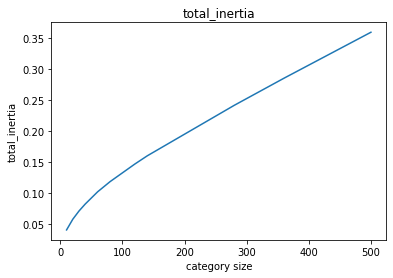

In [0]:
import matplotlib.pyplot as plt
plt.plot(cate, total_inertia1)
plt.xlabel('category size')
plt.ylabel('total_inertia')
plt.title('total_inertia')
plt.show()